In [1]:
import torch
from torch.func import functional_call
from lm_train.network import DNN
from lm_train.training_module import training_LM
import matplotlib.pyplot as plt

In [2]:
def model_u(data, params):
    return functional_call(model, params, (data, ))


def loss_target(params, *args, **kwargs):
    "General target loss"
    data, target, = args
    output = model_u(data, params)
    assert output.shape == target.shape, 'The shape of output and target should match'
    loss_b = output - target
    return loss_b


def exact(x):
    return torch.sinc(10 * x)

In [3]:
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_points = 1000
n_epoch = 1000

In [4]:
x = torch.linspace(-1, 1, n_points).reshape(-1, 1).to(device)
y = exact(x).to(device)
model = DNN([1, 100, 1]).to(device)
params = dict(model.named_parameters())
for p in params.values():
    p.requires_grad = False
losses = [loss_target]
inputs = [[x, y]]
kwargs = [{} for _ in range(len(losses))]
args = tuple(zip(losses, inputs, kwargs))

In [5]:
params, lossval_all, loss_running, lossval_test = training_LM(
    params,
    device,
    args,
    steps=n_epoch,
)

Step: 100. loss: 4.6073e-03. mu: 6.0507e-07.
Step: 200. loss: 9.8161e-04. mu: 9.5631e-09.
Step: 300. loss: 2.0147e-04. mu: 4.1985e-12.
Step: 400. loss: 4.9731e-07. mu: 6.6358e-14.
Step: 500. loss: 2.1178e-07. mu: 6.2928e-15.
Step: 600. loss: 5.4605e-10. mu: 2.1483e-14.
Step: 700. loss: 5.4605e-10. mu: 1.2224e-14.
Step: 800. loss: 5.8964e-11. mu: 4.1730e-14.
Step: 900. loss: 2.6718e-11. mu: 3.9573e-15.
Step: 1000. loss: 2.6718e-11. mu: 1.3510e-14.
training time: 12.159711122512817 (s).


In [6]:
# train the same model with Adam
model_adam = DNN([1, 100, 1]).to(device)
optimizer = torch.optim.Adam(model_adam.parameters(), lr=1e-3)
n_epoch_adam = 50000
for epoch in range(n_epoch_adam):
    optimizer.zero_grad()
    output = model_adam(x)
    loss = torch.mean((output - y) ** 2)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10000 == 0:
        print(f'Epoch: {epoch+1}, Loss: {loss.item():.4e}')

Epoch: 10000, Loss: 1.8070e-02
Epoch: 20000, Loss: 2.2029e-03
Epoch: 30000, Loss: 1.4621e-03
Epoch: 40000, Loss: 1.2265e-03
Epoch: 50000, Loss: 1.0886e-03


In [7]:
# calculate the L_inf error
x_test = torch.linspace(-1, 1, 100000).reshape(-1, 1).to(device)
y_test = exact(x_test).to(device)
output = model(x_test)
output_adam = model_adam(x_test)
print(f'L_inf error of LM: {torch.max(torch.abs(output - y_test)).item():.4e}')
print(f'L_inf error of Adam: {torch.max(torch.abs(output_adam - y_test)).item():.4e}')

L_inf error of LM: 4.9933e-05
L_inf error of Adam: 8.4715e-02


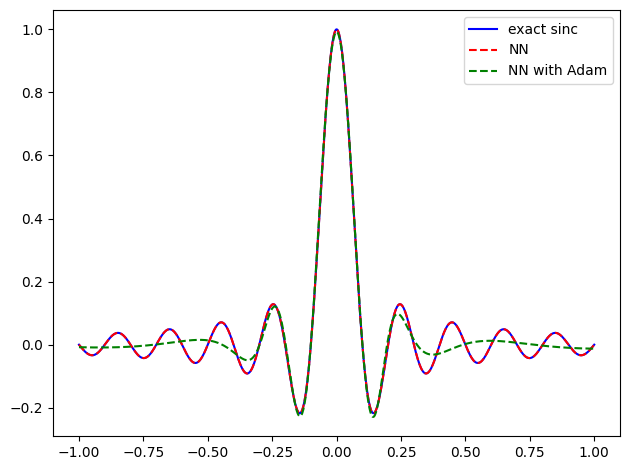

In [8]:
x = x.cpu().detach()
y = y.cpu().detach()
model = model.cpu()
model_adam = model_adam.cpu()
with torch.no_grad():
    plt.figure()
    plt.plot(x, y, 'b-', label="exact sinc")
    plt.plot(x, model(x), 'r--', label="NN")
    plt.plot(x, model_adam(x), 'g--', label="NN with Adam")
    plt.legend()
    plt.tight_layout()
    plt.savefig('img/sinc.png')
    plt.show()
